<Strong> Develop a TCN model that overfits , then do some regularization , then do some tuning. </Strong>

In [88]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop , Adam
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer , MaxPooling1D
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import math

In [89]:
#df_btc = pd.read_csv("../../cryptoData/BTC_1h_data.csv")
df_btc = pd.read_csv("BTC_1h_data.csv")

<Strong> Grabbing the closing price (univariate) </Strong>

In [90]:
# Removing everything but the closing price
btc_data = df_btc.values[:, 4 ,].astype(float)

btc_data[-1]

43534.54

<Strong> Scaling the data  </Strong>

In [91]:
percTrain = 70
percVal = 20 

In [92]:
scaler = MinMaxScaler()
    
onePercent = len(btc_data) // 100
numberTraining = onePercent * percTrain

reshaped_data = btc_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_btc = scaler.transform(reshaped_data)

<Strong> Creating Matrix in Sliding window form <Strong>

In [93]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

In [94]:
# Using 24 datapoints to predict the 25th

window_length = 24
dilation_rate = 2
kernel_size = 2

features = 1

sliding_winda_btc = sliding_window(scaled_btc , window_length)

<Strong> Splitting the data into train , val , test </Strong>

In [95]:
# Splitting the data after creating the sliding window data
def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

In [96]:
btc_train , btc_val , btc_test = splitting_train_test(sliding_winda_btc)

print(btc_train[0].shape)

(27370, 24, 1)


In [97]:
# Hyper Parameters To Overfit 

# Add Layers 
# Train longer


<Strong> The number of layers while changing dilation_base , kernel_size or window_size. </Strong>

In [98]:
def getLayers(dilation_rate , window_size , kernel_size):
    
    top = (dilation_rate - 1) * (window_size - 1)
    bottom = (kernel_size - 1) 
    
    division = (top / bottom) + 1 
    log = math.ceil(math.log(division , dilation_rate))
    
    
    # This inequality must hold true for full coverage
    
    first = 1 + (kernel_size - 1)
    second = (dilation_rate ** log ) - 1
    third = dilation_rate - 1
    
    inequality = (second / third) * first
    
    if ( (kernel_size < dilation_rate) or (inequality < window_size) ):
        print("not going to have full coverage")
    
    else:
        print("layers =" , log , "kernel size =" , kernel_size , "dilation rate =" , dilation_rate )

    return log , dilation_rate , kernel_size

In [99]:
def createModel(model_params):
    
    num_layers = model_params[0]
    dilation = model_params[1]
    kernel_size = model_params[2]
    
    print(num_layers,dilation_rate)
    
    model1 = models.Sequential()
    
    # Casual adds padding to the start of input sequence
    model1.add(Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(window_length, features), dilation_rate=1 , padding = 'causal'))

    #minus one for the base conv1d layer ^
    for i in range (1 , num_layers):
        
        # For full coverage we need 4 layers 
        model1.add(Conv1D(filters=32, kernel_size=kernel_size, activation='relu' , padding = 'causal', dilation_rate= dilation**i))

    model1.add(Dense(128, activation='relu'))

    model1.add(Dense(1))

    model1.summary()
    
    return model1


In [100]:
model1 = createModel(getLayers(dilation_rate , window_length , kernel_size))

layers = 5 kernel size = 2 dilation rate = 2
5 2
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_75 (Conv1D)          (None, 24, 32)            96        
                                                                 
 conv1d_76 (Conv1D)          (None, 24, 32)            2080      
                                                                 
 conv1d_77 (Conv1D)          (None, 24, 32)            2080      
                                                                 
 conv1d_78 (Conv1D)          (None, 24, 32)            2080      
                                                                 
 conv1d_79 (Conv1D)          (None, 24, 32)            2080      
                                                                 
 dense_30 (Dense)            (None, 24, 128)           4224      
                                                                 
 den

In [101]:
opt = Adam(0.001)
model1.compile(optimizer=opt , loss = 'mse')

In [102]:
history = model1.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =30 , verbose = 1 )

Epoch 1/30
54/54 [==============================] - 3s 47ms/step - loss: 0.0251 - val_loss: 0.2865
Epoch 2/30
54/54 [==============================] - 2s 41ms/step - loss: 0.0011 - val_loss: 0.0555
Epoch 3/30
54/54 [==============================] - 2s 41ms/step - loss: 3.7039e-04 - val_loss: 0.0310
Epoch 4/30
54/54 [==============================] - 2s 42ms/step - loss: 3.2776e-04 - val_loss: 0.0276
Epoch 5/30
54/54 [==============================] - 2s 42ms/step - loss: 3.2388e-04 - val_loss: 0.0206
Epoch 6/30
54/54 [==============================] - 2s 44ms/step - loss: 3.1610e-04 - val_loss: 0.0197
Epoch 7/30
54/54 [==============================] - 2s 42ms/step - loss: 3.0893e-04 - val_loss: 0.0194
Epoch 8/30
54/54 [==============================] - 2s 41ms/step - loss: 3.0680e-04 - val_loss: 0.0202
Epoch 9/30
54/54 [==============================] - 2s 44ms/step - loss: 2.9869e-04 - val_loss: 0.0190
Epoch 10/30
54/54 [==============================] - 2s 42ms/step - loss: 2.9899e

KeyboardInterrupt: 

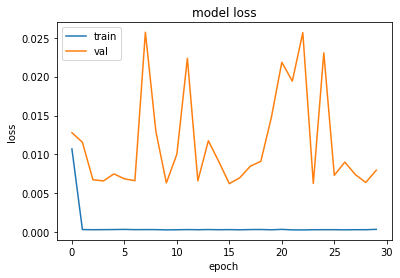

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.ylim([0,0.01])
plt.show()